In [148]:
import pandas as pd
import matplotlib.pyplot as plt 
import time
import datetime
import numpy as np
import time
from scipy.optimize import minimize

import numba
from numba import jit

In [2]:
def to_ts(date):
    if   "-" in date:
        forme = "%Y-%m-%d"
    elif "/" in date:
        forme = "%m/%d/%Y"
        
    return time.mktime(datetime.datetime.strptime(date, forme).timetuple())

In [3]:
df = pd.read_excel('DF(t) .xlsx')
df2 = pd.read_excel('Bloom_EUR_OIS.xlsx')
df.columns=['t','DF(t)']

In [4]:
df.tail()

,t,DF(t)
18257,2070-12-27,1.069258
18258,2070-12-28,1.069266
18259,2070-12-29,1.069274
18260,2070-12-30,1.069282
18261,2070-12-31,1.069290


In [5]:
df2.head()

,Payment Date,Maturity Date,Market Rate,Shift (bp),Shifted Rate,Zero Rate,Discount,Source
0,01/06/2021,01/06/2021,-0.4980,0,-0.4980,-0.504920,1.000014,CASH
1,01/12/2021,01/12/2021,-0.4700,0,-0.4700,-0.476550,1.000091,DETAILED_SWAP
2,01/19/2021,01/19/2021,-0.4700,0,-0.4700,-0.476572,1.000183,DETAILED_SWAP
3,02/05/2021,02/05/2021,-0.4719,0,-0.4719,-0.478551,1.000407,DETAILED_SWAP
4,03/05/2021,03/05/2021,-0.4750,0,-0.4750,-0.481785,1.000779,DETAILED_SWAP


In [6]:
def append_m_rate(date):
    k=0
    try:
        while not to_ts(df2.T[k]['Payment Date'])<= to_ts(date) <= to_ts(df2.T[k+1]['Payment Date']):
            k+=1

        return df2.T[k]['Market Rate']
    except:
        return 0.0

def keep_date(date_w_hours):
    return str(date_w_hours).split(" ")[0]

#df['t'] = df['t'].apply(keep_date)

In [7]:
#df['Market Rate'] = df['t'].apply(append_m_rate)
df['t']

0       2021-01-01
1       2021-01-02
2       2021-01-03
3       2021-01-04
4       2021-01-05
           ...    
18257   2070-12-27
18258   2070-12-28
18259   2070-12-29
18260   2070-12-30
18261   2070-12-31
Name: t, Length: 18262, dtype: datetime64[ns]

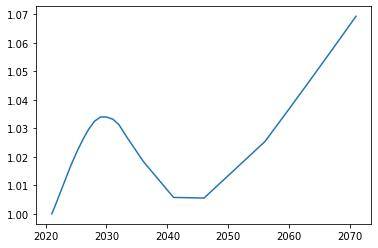

In [8]:
plt.plot(df['t'],df['DF(t)'])
plt.show()

In [9]:
df['t'][0]

df['t'][1]

(df['t'][1]<df['t'][0])

df.head()

,t,DF(t)
0,2021-01-01,1.0
1,2021-01-02,1.0
2,2021-01-03,1.0
3,2021-01-04,1.0
4,2021-01-05,1.0


In [169]:
# P = DF
class Stripper:
    def __init__(self):
        #self.df = pd.read_excel('DF(t) .xlsx')
        self.df = pd.read_csv('data.csv')
        self.df2 = pd.read_excel('Bloom_EUR_OIS.xlsx')
        self.df2['Payment Date'] = self.df2['Payment Date'].apply(self.temps)
        #self.df.columns=['t','DF(t)']
        
        self.df['t'] = pd.to_datetime(self.df['t'])
        self.df['t'] = self.df['t'].apply(datetime.datetime.timestamp)
        self.df['t'] = self.df['t']/86400
        self.df['P'] = self.df['t'].apply(self.P)
        self.n = 100#len(self.df)
        self.N = 100000
        self.R = .4
        self.LGD = 1-self.R
    
    def temps(self,x):
        return datetime.datetime.strptime(x,  "%m/%d/%Y")
    
    
    def delta(self,t1,t2):
        return (t2-t1)#.days
            
    #def P(self,T):
    #    return np.average(self.df[self.df.t <= T]['DF(t)'])
    
    def P(self,T):
        return np.mean(self.df[self.df.t <= T]['DF(t)'])

    
    def F(self,t,S,T):
        return (self.P(S)/self.P(T)-1)/self.delta(S,T)
        
        
        
    def m_rate(self,date):
        k=0
        max_k = len(self.df2.T)
        while not self.df2.T[k]['Payment Date']<= date :#<= self.df2.T[k+1]['Payment Date']:
            k+=1
            if k == max_k-2:
                print("error")
                break

        return self.df2.T[k]['Market Rate']

        
    def append_m_rate(self):
        self.df['MarketRate'] = np.vectorize(self.m_rate)(self.df['t'])
    
        
    def append_prices(self):
        self.df['V'] = np.cumsum(self.df['MarketRate']*self.df['DF(t)'])

        
        
    def polynome(self,t, p = .5):
        
        #t = self.df['t'][i]
        s  = 0
        P  = list(self.df['P'])
        t_ = list(self.df['t'])
        
        
        for j in range(1+list(self.df['t']).index(t),self.n):
            T    = t_[j]
            T_1  = t_[j-1]
            
            s +=    P[j]*         \
                    p**self.delta(t,T)*  \
                    self.F(t,T_1,T)*     \
                    self.delta(T_1,T)    \
                    +                    \
                    (p**self.delta(t,T_1) - p**self.delta(t,T))*(self.R)


        s += P[-1]* p**self.delta(t, t_[-1])

        return s
    
    
    def solve_polynome(self,t,V, epsilon = 1e-3):
        left = 0
        right= 1

        while right-left>epsilon :
        #while np.abs(val+V/self.N)>epsilon and max_iter>0:
            mid = (left+right) / 2
            if (self.polynome(t,left)+V/self.N)*(self.polynome(t,mid)+V/self.N) < 0:
                right = mid
            else:
                left = mid
            
            
            #max_iter-=1
            
        return left
    
    def append_PD(self):
        self.df['PD'] = np.vectorize(self.solve_polynome)(self.df['t'],self.df['V'])
    
        
    def plotting(self,V,t):
        
        P = np.linspace(0,1,100)
        Y = [self.polynome(t,p)+V/self.N for p in P]
        
        
        
        plt.plot(P,Y)
        plt.show()
        
        
         

In [170]:
stripper = Stripper()
stripper.append_prices()

In [171]:
stripper.df.tail()

,Unnamed: 0,t,DF(t),MarketRate,P,V
18257,18257,36884.958333,1.069258,-0.498,1.026126,-9329.958221
18258,18258,36885.958333,1.069266,-0.498,1.026129,-9330.490715
18259,18259,36886.958333,1.069274,-0.498,1.026131,-9331.023214
18260,18260,36887.958333,1.069282,-0.498,1.026133,-9331.555716
18261,18261,36888.958333,1.069290,-0.498,1.026136,-9332.088223


In [172]:
stripper.append_PD()

In [177]:
stripper.df.to_csv('PD.csv')

In [175]:
stripper.df['PS'] = stripper.df['PD']

In [176]:
stripper.df['PD'] = 1-stripper.df['PD']

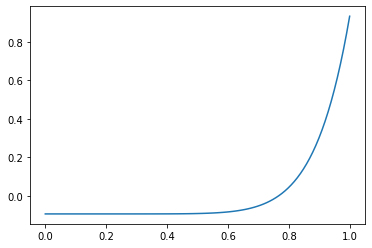

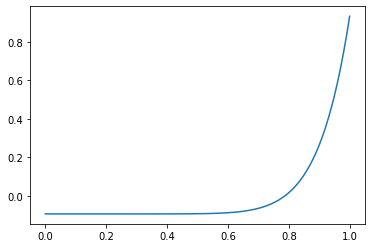

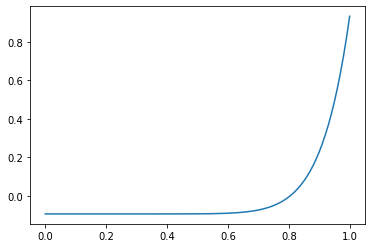

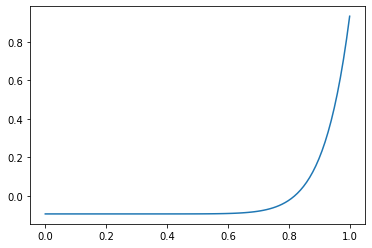

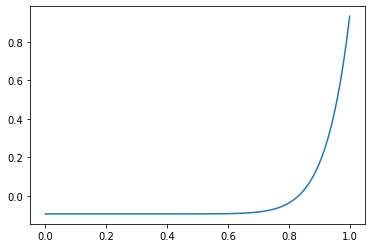

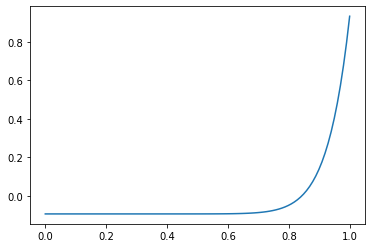

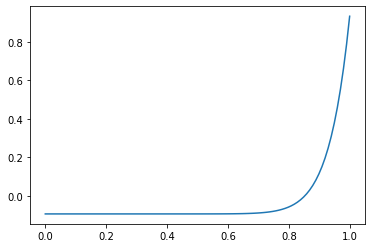

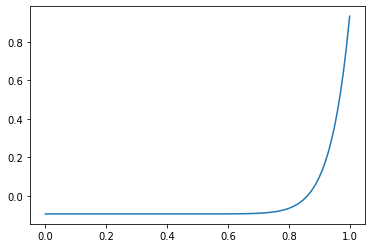

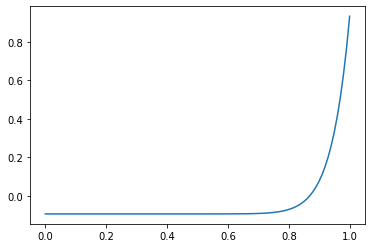

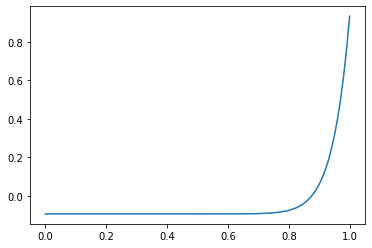

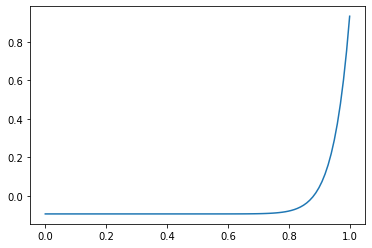

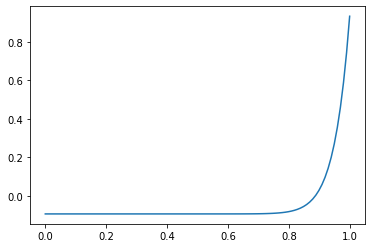

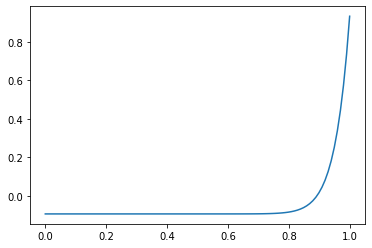

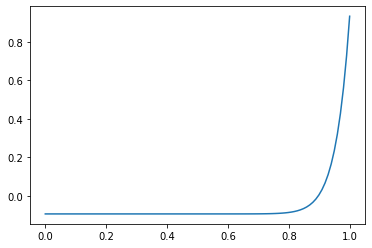

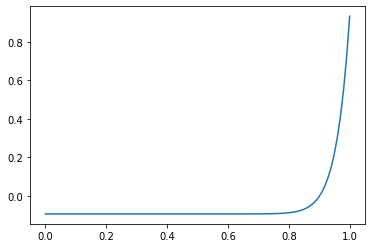

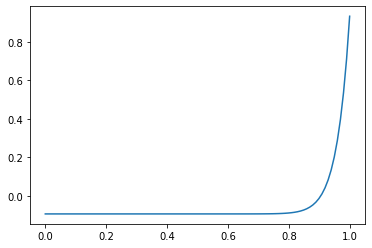

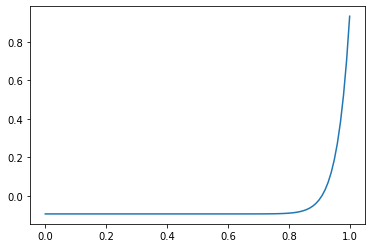

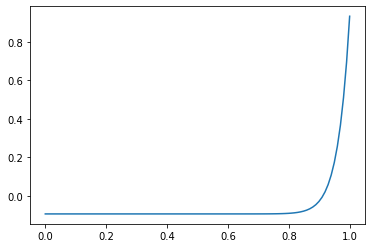

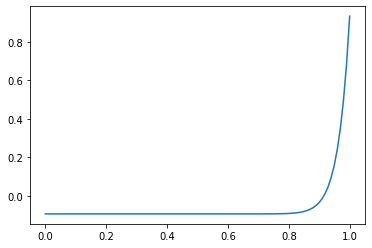

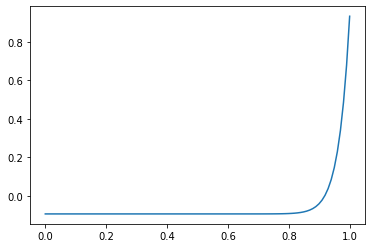

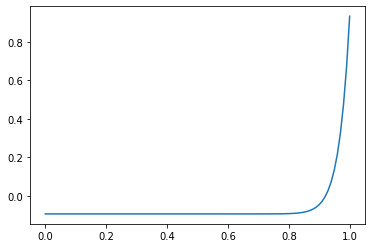

KeyboardInterrupt: 

In [159]:

for i in range(len(stripper.df['t'])-10,0,-1):

    t_i = stripper.df['t'][i]
    V_i = stripper.df['V'][i]


    stripper.plotting(V_i,t_i)
    #stripper.polynome(t)

In [168]:
print("évaluation du polynome pour différentes valeurs de t \navec p fixé p = 0.5 \n\n")
with open("p.txt",'w') as fichier:
    #for i in range(len(stripper.df['t'])):
    for i in range(len(stripper.df['t'])-10,0,-1):

        t_i = stripper.df['t'][i]
        V_i = stripper.df['V'][i]


        print("==================")
        t1 = time.time()
        p = stripper.solve_polynome(t_i, V_i)
        
        
                
        print("p = {}".format(p))
        fichier.write('{}\n'.format(p))
        print("Execution time = {}s".format(round(time.time()-t1,3)))
        #stripper.polynome(t)
        


évaluation du polynome pour différentes valeurs de t 
avec p fixé p = 0.5 


p = 0.765625
Execution time = 0.113s
p = 0.7861328125
Execution time = 0.087s
p = 0.8037109375
Execution time = 0.095s
p = 0.818359375
Execution time = 0.099s
p = 0.8310546875
Execution time = 0.086s
p = 0.841796875
Execution time = 0.094s
p = 0.8515625
Execution time = 0.089s
p = 0.8603515625
Execution time = 0.084s
p = 0.8681640625
Execution time = 0.085s
p = 0.875
Execution time = 0.094s
p = 0.880859375
Execution time = 0.084s
p = 0.88671875
Execution time = 0.089s
p = 0.8916015625
Execution time = 0.101s
p = 0.896484375
Execution time = 0.092s
p = 0.900390625
Execution time = 0.093s
p = 0.904296875
Execution time = 0.091s
p = 0.908203125
Execution time = 0.084s
p = 0.9111328125
Execution time = 0.097s
p = 0.9140625
Execution time = 0.103s
p = 0.9169921875
Execution time = 0.083s
p = 0.919921875
Execution time = 0.087s
p = 0.9228515625
Execution time = 0.098s
p = 0.9248046875
Execution time = 0.083s
p = 0.9

p = 0.9833984375
Execution time = 0.086s
p = 0.9833984375
Execution time = 0.093s
p = 0.9833984375
Execution time = 0.083s
p = 0.9833984375
Execution time = 0.086s
p = 0.984375
Execution time = 0.092s
p = 0.984375
Execution time = 0.083s
p = 0.984375
Execution time = 0.084s
p = 0.984375
Execution time = 0.102s
p = 0.984375
Execution time = 0.089s
p = 0.984375
Execution time = 0.085s
p = 0.984375
Execution time = 0.112s
p = 0.984375
Execution time = 0.108s
p = 0.984375
Execution time = 0.108s
p = 0.984375
Execution time = 0.095s
p = 0.984375
Execution time = 0.092s
p = 0.9853515625
Execution time = 0.091s
p = 0.9853515625
Execution time = 0.083s
p = 0.9853515625
Execution time = 0.085s
p = 0.9853515625
Execution time = 0.1s
p = 0.9853515625
Execution time = 0.11s
p = 0.9853515625
Execution time = 0.104s
p = 0.9853515625
Execution time = 0.095s
p = 0.9853515625
Execution time = 0.087s
p = 0.9853515625
Execution time = 0.094s
p = 0.9853515625
Execution time = 0.091s
p = 0.9853515625
Execu

p = 0.9912109375
Execution time = 0.106s
p = 0.9912109375
Execution time = 0.085s
p = 0.9912109375
Execution time = 0.085s
p = 0.9912109375
Execution time = 0.097s
p = 0.9912109375
Execution time = 0.107s
p = 0.9912109375
Execution time = 0.105s
p = 0.9912109375
Execution time = 0.106s
p = 0.9912109375
Execution time = 0.098s
p = 0.9912109375
Execution time = 0.095s
p = 0.9912109375
Execution time = 0.107s
p = 0.9912109375
Execution time = 0.1s
p = 0.9912109375
Execution time = 0.104s
p = 0.9912109375
Execution time = 0.106s
p = 0.9912109375
Execution time = 0.096s
p = 0.9912109375
Execution time = 0.097s
p = 0.9912109375
Execution time = 0.086s
p = 0.9912109375
Execution time = 0.083s
p = 0.9912109375
Execution time = 0.084s
p = 0.9921875
Execution time = 0.098s
p = 0.9921875
Execution time = 0.083s
p = 0.9921875
Execution time = 0.103s
p = 0.9921875
Execution time = 0.114s
p = 0.9921875
Execution time = 0.103s
p = 0.9921875
Execution time = 0.096s
p = 0.9921875
Execution time = 0.096

p = 0.994140625
Execution time = 0.092s
p = 0.994140625
Execution time = 0.094s
p = 0.994140625
Execution time = 0.094s
p = 0.994140625
Execution time = 0.107s
p = 0.994140625
Execution time = 0.102s
p = 0.994140625
Execution time = 0.103s
p = 0.994140625
Execution time = 0.099s
p = 0.994140625
Execution time = 0.089s
p = 0.994140625
Execution time = 0.087s
p = 0.994140625
Execution time = 0.106s
p = 0.994140625
Execution time = 0.107s
p = 0.994140625
Execution time = 0.105s
p = 0.994140625
Execution time = 0.106s
p = 0.994140625
Execution time = 0.099s
p = 0.994140625
Execution time = 0.1s
p = 0.994140625
Execution time = 0.099s
p = 0.994140625
Execution time = 0.094s
p = 0.994140625
Execution time = 0.1s
p = 0.994140625
Execution time = 0.106s
p = 0.994140625
Execution time = 0.103s
p = 0.994140625
Execution time = 0.106s
p = 0.994140625
Execution time = 0.101s
p = 0.994140625
Execution time = 0.104s
p = 0.994140625
Execution time = 0.107s
p = 0.994140625
Execution time = 0.104s
p = 

KeyboardInterrupt: 

In [ ]:
!code .